In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
from random import gauss, seed
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm 

%matplotlib inline 

pd.set_option('display.max_columns', None)

In [2]:
#Files in the main folder

!ls

Movie_Studio_Strategy_Recommendation.ipynb
README.md
data


In [3]:
#Files in the data folder

!ls data

README.md
bom.movie_gross.csv.gz
im.db
rt.movie_info.tsv.gz
rt.reviews.tsv.gz
tmdb.movies.csv.gz
tn.movie_budgets.csv.gz


In [4]:
#Initiating SQL connection

conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()

In [5]:
#Tables and schema

df = pd.read_sql("""
SELECT *
FROM sqlite_master""", conn)

df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [6]:
movie_gross_df = pd.read_csv("data/bom.movie_gross.csv.gz")

movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [7]:
movie_info_df = pd.read_csv("data/rt.movie_info.tsv.gz", sep="\t", encoding='windows-1252')

movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [8]:
movie_reviews_df = pd.read_csv("data/rt.reviews.tsv.gz", sep="\t", encoding='windows-1252')

movie_reviews_df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [9]:
movie_tmdb_df = pd.read_csv("data/tmdb.movies.csv.gz")

movie_tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [10]:
movie_budget_df = pd.read_csv("data/tn.movie_budgets.csv.gz")

movie_budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [11]:
##Sam Start here

In [12]:
#Starting with movie budget dataframe

movie_budget_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [13]:
budget = movie_budget_df['production_budget'].str.replace('$','').str.replace(',','').astype(np.int64)

In [14]:
worldwide_gross = movie_budget_df['worldwide_gross'].str.replace('$','').str.replace(',','').astype(np.int64)


In [15]:
#Defining X variable as Production Budget
#Defining Y Variable as Worldwide Gross Ticket Sales

### Change Y Variable - Use Profits instead of Sales

worldwide_gross = np.array(worldwide_gross)

x_production_budget = np.array(budget)
y_profit = worldwide_gross - x_production_budget

#We are printing out just 5 values in each array to double check the math
print(worldwide_gross[:5])
print(x_production_budget[:5])
print(y_profit[:5])

[2776345279 1045663875  149762350 1403013963 1316721747]
[425000000 410600000 350000000 330600000 317000000]
[2351345279  635063875 -200237650 1072413963  999721747]


In [16]:
#Manually Build Out Linear Regression
rho = np.corrcoef(x_production_budget, y_profit)[0][1]
s_y = y_profit.std()
s_x = x_production_budget.std()

m = rho * s_y / s_x

mean_y = y_profit.mean()
mean_x = x_production_budget.mean()
c = mean_y - m * mean_x

print(f"Our regression line is: y = {round(m, 5)}x + {round(c, 5)}")

Our regression line is: y = 2.12694x + -7285667.05459


In [17]:
x_production_budget_plus_c = sm.add_constant(x_production_budget)

In [18]:
model = sm.OLS(y_profit, x_production_budget_plus_c).fit()

In [19]:
#We are running 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     3403.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        04:57:39   Log-Likelihood:            -1.1557e+05
No. Observations:                5782   AIC:                         2.311e+05
Df Residuals:                    5780   BIC:                         2.311e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.286e+06   1.91e+06     -3.813      0.000    -1.1e+07   -3.54e+06
x1             2.1269      0.036     58.336      0.000       2.055       2.198
==============================================================================
Omnibus:                     4232.022   Durbin-Watson:                   1.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           172398.262
Skew:                           3.053   Prob(JB):                         0.00
Kurtosis:                      29.044   Cond. No.                     6.57e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.57e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
#Creating custom number formatters for charting purposes
def MM_formatter(x, pos):
    return f'${x/1e6:.1f} MM'

def Bn_formatter(x,pos):
    return f'${x/1e9:.1f} Bn'

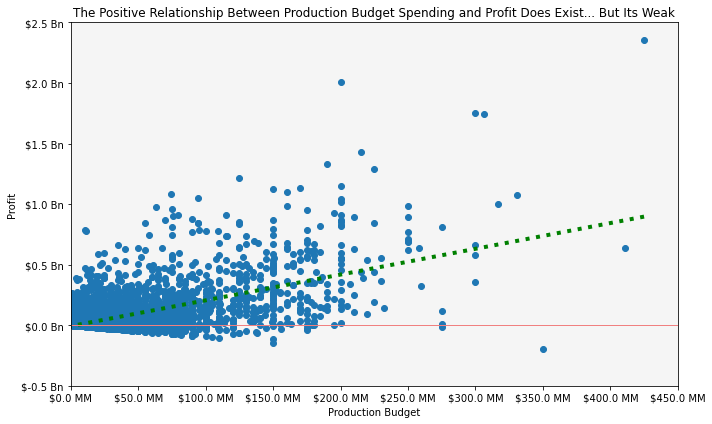

In [70]:
#Look at Scatter Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor('whitesmoke')

ax.scatter(x_production_budget, y_profit)
ax.plot(x_production_budget, (m*x_production_budget+c), linewidth=4, color='g', linestyle=':')

#This line hear is y=0. All the data points below this are unprofitable
ax.axhline(linewidth=1, color='lightcoral') 

#Create a ScalarFormatter object
formatter1 = ticker.FuncFormatter(MM_formatter)
formatter2 = ticker.FuncFormatter(Bn_formatter)

#Applying the formatter to both x and y axes
ax.yaxis.set_major_formatter(formatter2)
ax.xaxis.set_major_formatter(formatter1)

ax.set_xlabel('Production Budget')
ax.set_ylabel('Profit')
ax.set_title('The Positive Relationship Between Production Budget Spending and Profit Does Exist... But Its Weak')

plt.xlim(0,4.5e8)
plt.ylim(-.5e9,2.5e9)
plt.tight_layout()

###Also rerun the analysis for a genre subset - comedy and not comedy
###Need to add a join
###Also would be good to run a two sample ttest

In [29]:
#Pulling needed data from IMDB database using SQL

df_movie_imdb = pd.read_sql("""
  SELECT mb.movie_id, 
         mb.primary_title, 
         mb.genres, 
         p.primary_name, 
         p.birth_year, 
         p.death_year, 
         p.primary_profession
    FROM movie_basics AS mb
    JOIN directors AS d
      ON mb.movie_id = d.movie_id
    JOIN persons AS p
      ON d.person_id = p.person_id
GROUP BY mb.movie_id, p.primary_name""", conn)

In [30]:
#Combining Movie Budget Database with IMDB information

df_merged_mb = movie_budget_df.merge(df_movie_imdb, left_on='movie', right_on='primary_title')

df_merged_mb

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,primary_title,genres,primary_name,birth_year,death_year,primary_profession
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309,Avatar,Horror,Atsushi Wada,NaN,NaN,director
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",Rob Marshall,1960.0,NaN,"director,miscellaneous,producer"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",tt6565702,Dark Phoenix,"Action,Adventure,Sci-Fi",Simon Kinberg,1973.0,NaN,"producer,writer,director"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",Joss Whedon,1964.0,NaN,"writer,producer,director"
4,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",tt4154756,Avengers: Infinity War,"Action,Adventure,Sci-Fi",Anthony Russo,1970.0,NaN,"producer,director,writer"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169,70,"Apr 1, 1996",Bang,"$10,000",$527,$527,tt6616538,Bang,None,Zarina Tadjibaeva,NaN,NaN,"actress,producer,director"
4170,73,"Jan 13, 2012",Newlyweds,"$9,000","$4,584","$4,584",tt1880418,Newlyweds,"Comedy,Drama",Edward Burns,1968.0,NaN,"actor,writer,producer"
4171,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,tt7837402,Red 11,"Horror,Sci-Fi,Thriller",Robert Rodriguez,1968.0,NaN,"producer,writer,director"
4172,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,tt2107644,A Plague So Pleasant,"Drama,Horror,Thriller",Benjamin Roberds,NaN,NaN,"camera_department,director,writer"


In [35]:
df_merged_mb['comedy_or_other'] = df_merged_mb['genres'].apply(lambda x: 'Comedy' if x is not None and 'Comedy' in x else 'Other')

In [36]:
df_merged_mb['comedy_or_other'].value_counts()

Other     3199
Comedy     975
Name: comedy_or_other, dtype: int64

In [37]:
df_merged_mb['production_budget'] = df_merged_mb['production_budget'].str.replace('$','').str.replace(',','').astype(np.int64)
df_merged_mb['domestic_gross'] = df_merged_mb['domestic_gross'].str.replace('$','').str.replace(',','').astype(np.int64)
df_merged_mb['worldwide_gross'] = df_merged_mb['worldwide_gross'].str.replace('$','').str.replace(',','').astype(np.int64)

In [39]:
df_merged_mb['profit'] = df_merged_mb['worldwide_gross'] - df_merged_mb['production_budget']

In [40]:
df_merged_mb

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,primary_title,genres,primary_name,birth_year,death_year,primary_profession,comedy_or_other,profit
0,1,"Dec 18, 2009",Avatar,425000000,"$760,507,625",2776345279,tt1775309,Avatar,Horror,Atsushi Wada,NaN,NaN,director,Other,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,"$241,063,875",1045663875,tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",Rob Marshall,1960.0,NaN,"director,miscellaneous,producer",Other,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,"$42,762,350",149762350,tt6565702,Dark Phoenix,"Action,Adventure,Sci-Fi",Simon Kinberg,1973.0,NaN,"producer,writer,director",Other,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,"$459,005,868",1403013963,tt2395427,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",Joss Whedon,1964.0,NaN,"writer,producer,director",Other,1072413963
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000,"$678,815,482",2048134200,tt4154756,Avengers: Infinity War,"Action,Adventure,Sci-Fi",Anthony Russo,1970.0,NaN,"producer,director,writer",Other,1748134200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169,70,"Apr 1, 1996",Bang,10000,$527,527,tt6616538,Bang,None,Zarina Tadjibaeva,NaN,NaN,"actress,producer,director",Other,-9473
4170,73,"Jan 13, 2012",Newlyweds,9000,"$4,584",4584,tt1880418,Newlyweds,"Comedy,Drama",Edward Burns,1968.0,NaN,"actor,writer,producer",Comedy,-4416
4171,78,"Dec 31, 2018",Red 11,7000,$0,0,tt7837402,Red 11,"Horror,Sci-Fi,Thriller",Robert Rodriguez,1968.0,NaN,"producer,writer,director",Other,-7000
4172,81,"Sep 29, 2015",A Plague So Pleasant,1400,$0,0,tt2107644,A Plague So Pleasant,"Drama,Horror,Thriller",Benjamin Roberds,NaN,NaN,"camera_department,director,writer",Other,-1400


In [12]:
len(movie_budget_df)

5782

In [17]:
movie_budget_df['movie'].value_counts()

King Kong                      3
Halloween                      3
Home                           3
The Gambler                    2
The Mummy                      2
                              ..
Madagascar: Escape 2 Africa    1
Rubber                         1
Feng kuang de shi tou          1
Wreck-It Ralph                 1
Men of Honor                   1
Name: movie, Length: 5698, dtype: int64

In [19]:
movie_budget_df[movie_budget_df['movie'] == 'King Kong']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
39,40,"Dec 14, 2005",King Kong,"$207,000,000","$218,080,025","$550,517,357"
2374,75,"Dec 17, 1976",King Kong,"$23,000,000","$52,614,445","$90,614,445"
5396,97,"Apr 7, 1933",King Kong,"$672,000","$10,000,000","$10,000,650"


In [20]:
movie_budget_df[movie_budget_df['movie'] == 'Halloween']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
3014,15,"Aug 31, 2007",Halloween,"$15,000,000","$58,269,151","$77,514,401"
3535,36,"Oct 19, 2018",Halloween,"$10,000,000","$159,342,015","$254,900,667"
5536,37,"Oct 17, 1978",Halloween,"$325,000","$47,000,000","$70,000,000"


It seems safe to conclude there are no duplicates in the movie_budget_df

In [16]:
len(movie_gross_df)

3387

In [15]:
df_movie_basics = pd.read_sql("""
SELECT *
FROM movie_basics""", conn)

df_movie_basics['genres'].value_counts()

#seeing 1085 variations of genres/combos of genres

Documentary                    32185
Drama                          21486
Comedy                          9177
Horror                          4372
Comedy,Drama                    3519
                               ...  
Adventure,Horror,Romance           1
Fantasy,History,Sci-Fi             1
Animation,Crime                    1
Action,Documentary,Thriller        1
Fantasy,Music,Sci-Fi               1
Name: genres, Length: 1085, dtype: int64

In [ ]:
##Sangwon Start here

In [ ]:
#Sarah start here